# Imports

In [1]:
import random
import imutils

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import tensorflow as tf
import keras
print(tf.config.list_physical_devices('GPU'))

import cv2

/tmp/ipykernel_7238/738579589.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-06 13:32:48.105455: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-06 13:32:48.105495: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-06 13:32:48.106371: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-02-06 13:32:50.273303: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 13:32:50.310218: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 13:32:50.310742: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [2]:
tf.__version__, keras.__version__

('2.15.0', '3.0.0')

# Data load

In [3]:
let = cv2.imread('data/letterlist.jpg', 0)
let = let[15:780,:]
num_letters = 33
num_fonts = 21
num_classes = 33
input_shape = (32,32,1)

def get_letter(font_num, letter_num):
    letter = let[let.shape[0]//num_fonts*(font_num-1):let.shape[0]//num_fonts*font_num,
           let.shape[1]//num_letters*(letter_num-1):let.shape[1]//num_letters*letter_num,
           ]
    return cv2.resize(letter, input_shape[:-1])

def get_letter_variants(letter_num):
        return let[:,
           let.shape[1]//num_letters*(letter_num-1):let.shape[1]//num_letters*letter_num,
           ]

def get_font_variants(font_num):
    return let[let.shape[0]//num_fonts*(font_num-1):let.shape[0]//num_fonts*font_num,
           :,
           ]
test = get_letter(21,33)
print(test.shape)
plt.imshow(test, cmap='gray')

[ WARN:0@2.954] global loadsave.cpp:248 findDecoder imread_('data/letterlist.jpg'): can't open/read file: check file path/integrity


TypeError: 'NoneType' object is not subscriptable

# Augmenters

In [ ]:
class BaseAugmenter():
    def __init__(self, chanse=0.5):
        self.chance = chanse
        
    def __call__(self, img, *args, **kwargs):
        augmented = False
        if random.random()<= self.chance:
            try:
                img = self._apply(img, *args, **kwargs)
                augmented = True
            except Exception as e:
                print(e)
            
        return img, augmented
    
    def _apply(self, img, *args, **kwargs):
        return img
    
class NoiseAugmenter(BaseAugmenter):
    def _apply(self, letter, max=30):
        noise = np.random.normal(size=(letter.shape))*max
        return letter+noise
    
plt.imshow(NoiseAugmenter(1)(test)[0], cmap='gray')
plt.xticks([])
plt.yticks([])

In [ ]:
class FlipAugmenter(BaseAugmenter):

    def _apply(self, letter, mode='horizontal'):
        if mode == 'horizontal':
            return np.flip(letter, axis=0)
        elif mode == 'vertical':
            return np.flip(letter, axis=1)
        elif mode == 'random':
            axis = random.random() < 0.5
            return np.flip(letter, axis=int(axis))
        
plt.imshow(FlipAugmenter(1)(test)[0], cmap='gray')  

In [ ]:
class RotationAugmenter(BaseAugmenter):
    
    def _apply(self, letter, angle=60):
        image = np.zeros_like(letter) + 255 - letter
        rotated = imutils.rotate_bound(image, angle)
        rotated = np.zeros_like(rotated) + 255 - rotated
        rotated = cv2.resize(rotated, (letter.shape[1], letter.shape[0]))
        return rotated
rotated = RotationAugmenter(1)(test)[0]
plt.imshow(rotated, cmap='gray')

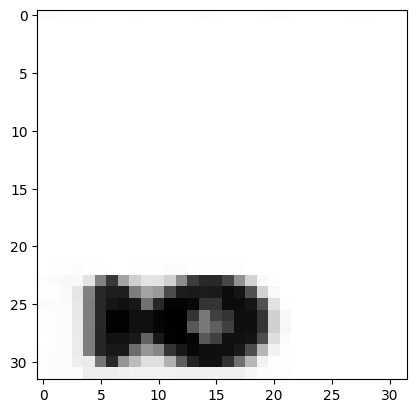

In [7]:
class BlurAugmenter(BaseAugmenter):
    
    def _apply(self, letter, kernel_size=3):
        return cv2.medianBlur(letter, kernel_size)
    
plt.imshow(BlurAugmenter(1)(test)[0], cmap='gray')

In [8]:
class MultipleAugmenter():
    NOISE_CHANCE = 0.1
    NOISE_HARDNESS = 5
    
    FLIP_CHANCE = 0.2
    
    ROTATE_CHANCE = 0.15
    
    BLUR_CHANCE = 0.1
    BLUR_HARD_CHANCE = 0.15
    
    images = []
    captions = []
    
    def __init__(self, images, captions):
        self.images_orig = images
        self.captions_orig = captions
        self.augmenters = [
            FlipAugmenter(self.FLIP_CHANCE),
            # RotationAugmenter(self.ROTATE_CHANCE),
            BlurAugmenter(self.BLUR_CHANCE),
            # BlurAugmenter(self.BLUR_HARD_CHANCE),
            # NoiseAugmenter(self.NOISE_CHANCE)
        ]
        
        self.augment_args = [
            ['random'],
            # [],
            [3],
            # [5],
            # [self.NOISE_HARDNESS]
        ]    
    
    def random_augment(self, rounds = 1, seed = 42, save_last=False):
        random.seed(seed)
        
        images = self.images_orig
        captions = self.captions_orig
        
        for _ in range(rounds):
            print(len(images))
            num_images = len(images)
            for n in range(num_images):
                image = images[n]
                caption = captions[n]
                
                for n, aug in enumerate(self.augmenters):
                    aug_args = self.augment_args[n]
                    if not aug_args:
                        aug_args = [random.randint(-15,15)]
                    image, augmented = aug(image, *aug_args)
                    if augmented:
                        images.append(image)
                        captions.append(caption)
                    
            if save_last:
                images = images[num_images:]
                captions = captions[num_images:]
        self.images = images
        self.captions = captions

# Data preparation

In [9]:
images = []
captions = []
captions_base = "Ё Й Ц У К Е Н Г Ш Щ З Х Ъ Ф Ы В А П Р О Л Д Ж Э Я Ч С М И Т Ь Б Ю".split(' ')
for i in range(1, num_fonts+1):
    for j in range(1, num_letters+1):
        images.append(get_letter(i,j))
        captions.append(captions_base[j-1])

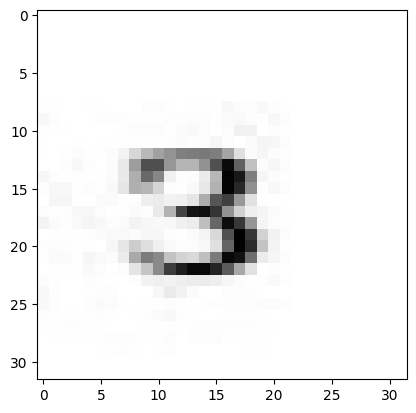

In [10]:
plt.imshow(images[10], cmap='gray')

In [11]:
len(images)

693

In [12]:
aug = MultipleAugmenter(images.copy(), captions.copy())

In [13]:
len(aug.images), len(images)

(0, 693)

In [14]:
aug.random_augment(8)

693
890
1149
1501
1956
2522
3302
4306


З


([], [])

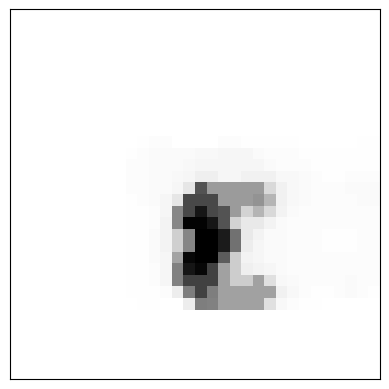

In [15]:
n = 4
print(aug.captions[-n])
plt.imshow(aug.images[-n], cmap='gray')
plt.xticks([])
plt.yticks([])

In [16]:
np.array(aug.images).shape

(5565, 32, 32)

## Train data

In [17]:
x_data = np.array(aug.images)
x_data = x_data.reshape(*x_data.shape, 1)
x_data.shape

(5565, 32, 32, 1)

In [18]:
classes = list(map(captions_base.index, aug.captions))
y_data = keras.utils.to_categorical(classes, num_classes=num_letters)

## Test Data

In [19]:
test_aug = MultipleAugmenter(images.copy(), captions.copy())
test_aug.random_augment(3, 65, 0)
len(test_aug.images), len(test_aug.captions)

693
914
1176


(1514, 1514)

In [20]:
test_x_data = np.array(test_aug.images)
test_x_data = test_x_data.reshape(*test_x_data.shape, 1)

test_classes = list(map(captions_base.index, test_aug.captions))
test_y_data = keras.utils.to_categorical(test_classes, num_classes=num_letters)

# Callbacks

In [21]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_delta = 1e-3,
                              patience=3, min_lr=1e-10)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=7)
tensorboard = keras.callbacks.TensorBoard(log_dir="./logs")

# Plain MLP

In [22]:
inputs = keras.layers.Input(shape=(*np.array(aug.images).shape[1:],1), name='inputs')
dense = keras.layers.Flatten()(inputs)
dense = keras.layers.Dense(1024, activation='relu')(dense)

dense = keras.layers.Dense(512, activation='relu')(dense)
dense = keras.layers.Dense(256, activation='relu')(dense)

dense = keras.layers.Dense(num_letters, activation='softmax')(dense)

mlp = keras.models.Model(inputs=inputs, outputs=dense)
mlp.summary()

2024-02-02 17:08:08.710278: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-02 17:08:08.710503: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-02 17:08:08.710675: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ inputs (InputLayer)             │ (None, 32, 32, 1)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten (Flatten)               │ (None, 1024)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 1024)              │  1,049,600 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 512)               │    524,800 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ (None, 256)               │    131,328 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_3 (Dense)                 │ (None, 33)                │      8,481 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 1,714,209 (6.54 MB)

 Trainable params: 1,714,209 (6.54 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200


2024-02-02 17:08:09.683694: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fc28c009d10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-02 17:08:09.683727: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-02-02 17:08:09.718166: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-02 17:08:09.860194: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


 1/35 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - categorical_accuracy: 0.0312 - loss: 610.7830

I0000 00:00:1706882890.603227    3131 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - categorical_accuracy: 0.0321 - loss: 682.5093 - val_categorical_accuracy: 0.0350 - val_loss: 59.3026 - learning_rate: 0.0010
Epoch 2/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.0313 - loss: 48.6957 - val_categorical_accuracy: 0.0386 - val_loss: 11.6275 - learning_rate: 0.0010
Epoch 3/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.0388 - loss: 8.1864 - val_categorical_accuracy: 0.0350 - val_loss: 4.8038 - learning_rate: 0.0010
Epoch 4/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.0443 - loss: 4.5607 - val_categorical_accuracy: 0.0494 - val_loss: 4.4235 - learning_rate: 0.0010
Epoch 5/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.0588 - loss: 4.1936 - val_categorical_accuracy: 0.0413 - val_loss: 4.0396 - learning_rate: 0.0010
Epoch 6/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.0602 - loss: 3.8522 - val_categorical_accuracy: 0.0638

<Axes: >

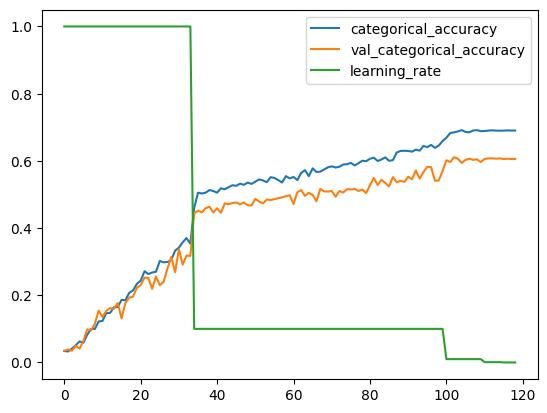

In [23]:
mlp.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'], optimizer='adam')
his = mlp.fit(x_data, y_data, 
        epochs=200, 
        shuffle=True, 
        batch_size=128, 
        validation_split=0.2, 
        callbacks=[reduce_lr, early_stop]
        )
his_df = pd.DataFrame(his.history)
his_df['learning_rate'] = his_df['learning_rate'].values*1000
his_df[['categorical_accuracy', 'val_categorical_accuracy','learning_rate']].plot()

In [24]:
mlp.evaluate(test_x_data, test_y_data, batch_size=32)

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.6061 - loss: 1.3324


[1.4578008651733398, 0.578599750995636]

In [25]:
pr = mlp.predict(test_x_data)

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [26]:
mlp.save("models/mlp.keras")

# CNN Model

In [27]:
inputs = keras.layers.Input(shape=(*np.array(aug.images).shape[1:],1), name='inputs')
conv = keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(inputs)
conv = keras.layers.MaxPool2D()(conv)
conv = keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(conv)
conv = keras.layers.MaxPool2D()(conv)
conv = keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(conv)
conv = keras.layers.MaxPool2D()(conv)

dense = keras.layers.Flatten()(conv)
dense = keras.layers.Dense(1024, activation='relu')(dense)
dense = keras.layers.Dense(512, activation='relu')(dense)
dense = keras.layers.Dense(256, activation='relu')(dense)
dense = keras.layers.Dense(num_letters, activation='softmax')(dense)

model = keras.models.Model(inputs=inputs, outputs=dense)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ inputs (InputLayer)             │ (None, 32, 32, 1)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 128)       │      1,280 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 128)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 256)       │    295,168 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 256)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 512)         │  1,180,160 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 512)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_4 (Dense)                 │ (None, 1024)              │  8,389,632 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_5 (Dense)                 │ (None, 512)               │    524,800 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_6 (Dense)                 │ (None, 256)               │    131,328 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_7 (Dense)                 │ (None, 33)                │      8,481 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 10,530,849 (40.17 MB)

 Trainable params: 10,530,849 (40.17 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
model.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'], optimizer='adam')

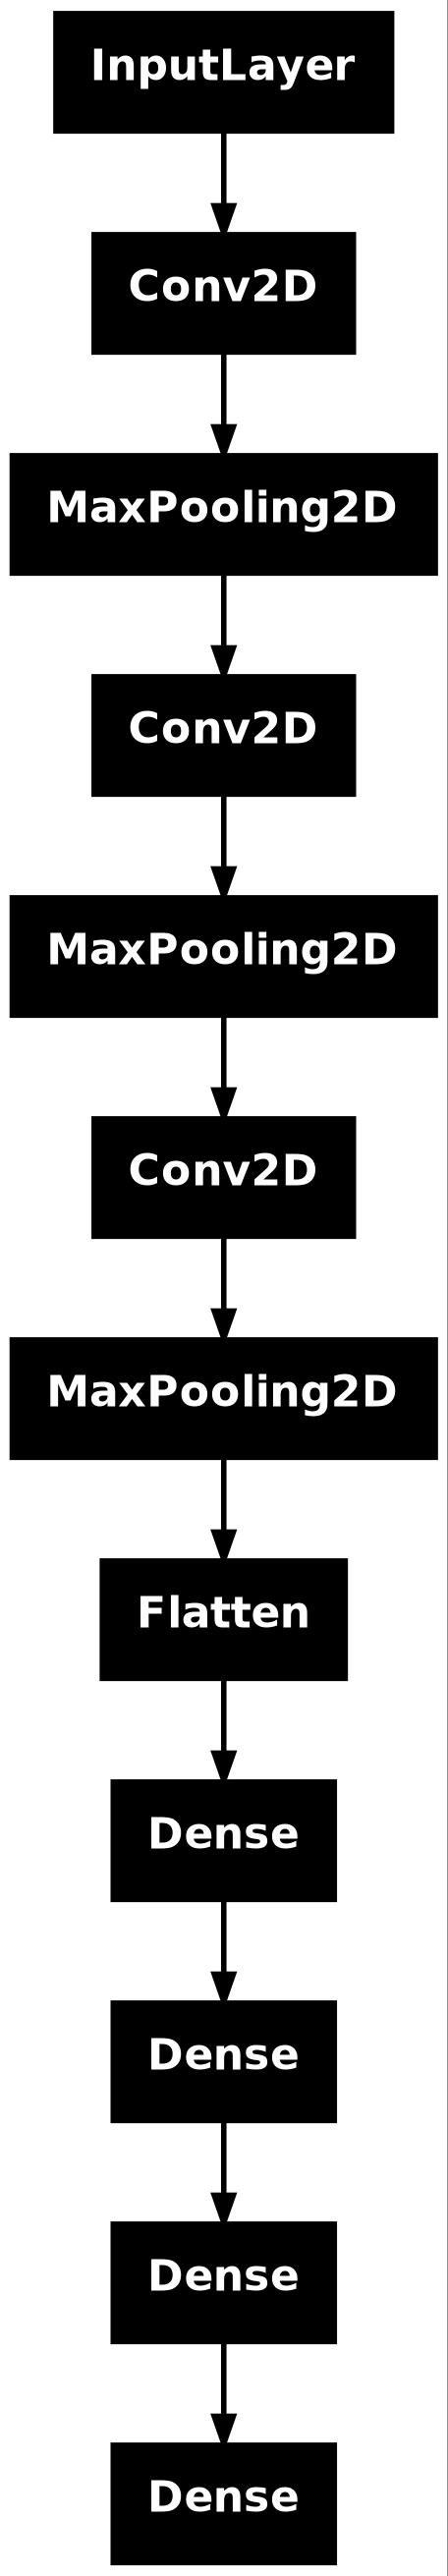

In [29]:
keras.utils.plot_model(model, 'models/CNN.jpg')

In [30]:
his = model.fit(x_data, y_data,
          epochs=50,
          batch_size=128,
          shuffle=True,
          validation_split=0.2,
          callbacks=[reduce_lr, early_stop, tensorboard],
                )

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 178ms/step - categorical_accuracy: 0.0385 - loss: 20.4156 - val_categorical_accuracy: 0.0413 - val_loss: 3.4856 - learning_rate: 0.0010
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - categorical_accuracy: 0.0463 - loss: 3.4693 - val_categorical_accuracy: 0.1384 - val_loss: 3.0853 - learning_rate: 0.0010
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - categorical_accuracy: 0.1794 - loss: 2.7827 - val_categorical_accuracy: 0.3801 - val_loss: 2.0403 - learning_rate: 0.0010
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - categorical_accuracy: 0.4517 - loss: 1.7393 - val_categorical_accuracy: 0.5750 - val_loss: 1.3466 - learning_rate: 0.0010
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - categorical_accuracy: 0.6905 - loss: 0.9491 - val_categorical_accuracy: 0.7520 - val_loss: 0.7504 - learning_rate: 0.0010
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - categorical_accuracy: 0.8258 - loss: 0.5361 - val_categorical_accurac

<Axes: >

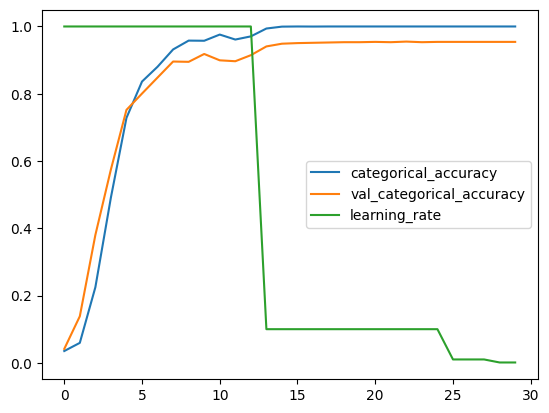

In [31]:
his_df = pd.DataFrame(his.history)
his_df['learning_rate'] = his_df['learning_rate'].values*1000
his_df[['categorical_accuracy', 'val_categorical_accuracy','learning_rate']].plot()

In [32]:
model.evaluate(test_x_data, test_y_data)

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - categorical_accuracy: 0.9864 - loss: 0.0504


[0.16044366359710693, 0.95772784948349]

In [65]:
y_pred = model.predict(test_x_data).argmax(axis=1)
len(y_pred), len(test_classes)

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


(1514, 1514)

In [66]:
mat = np.zeros(shape=(num_letters,num_letters))
for i in range(len(y_pred)):
    true_ind = test_classes[i]
    pred_ind = y_pred[i]    
    mat[true_ind, pred_ind]+=1

mat=mat/mat.sum(axis=0)

Text(0, 0.5, 'Predicted letters')

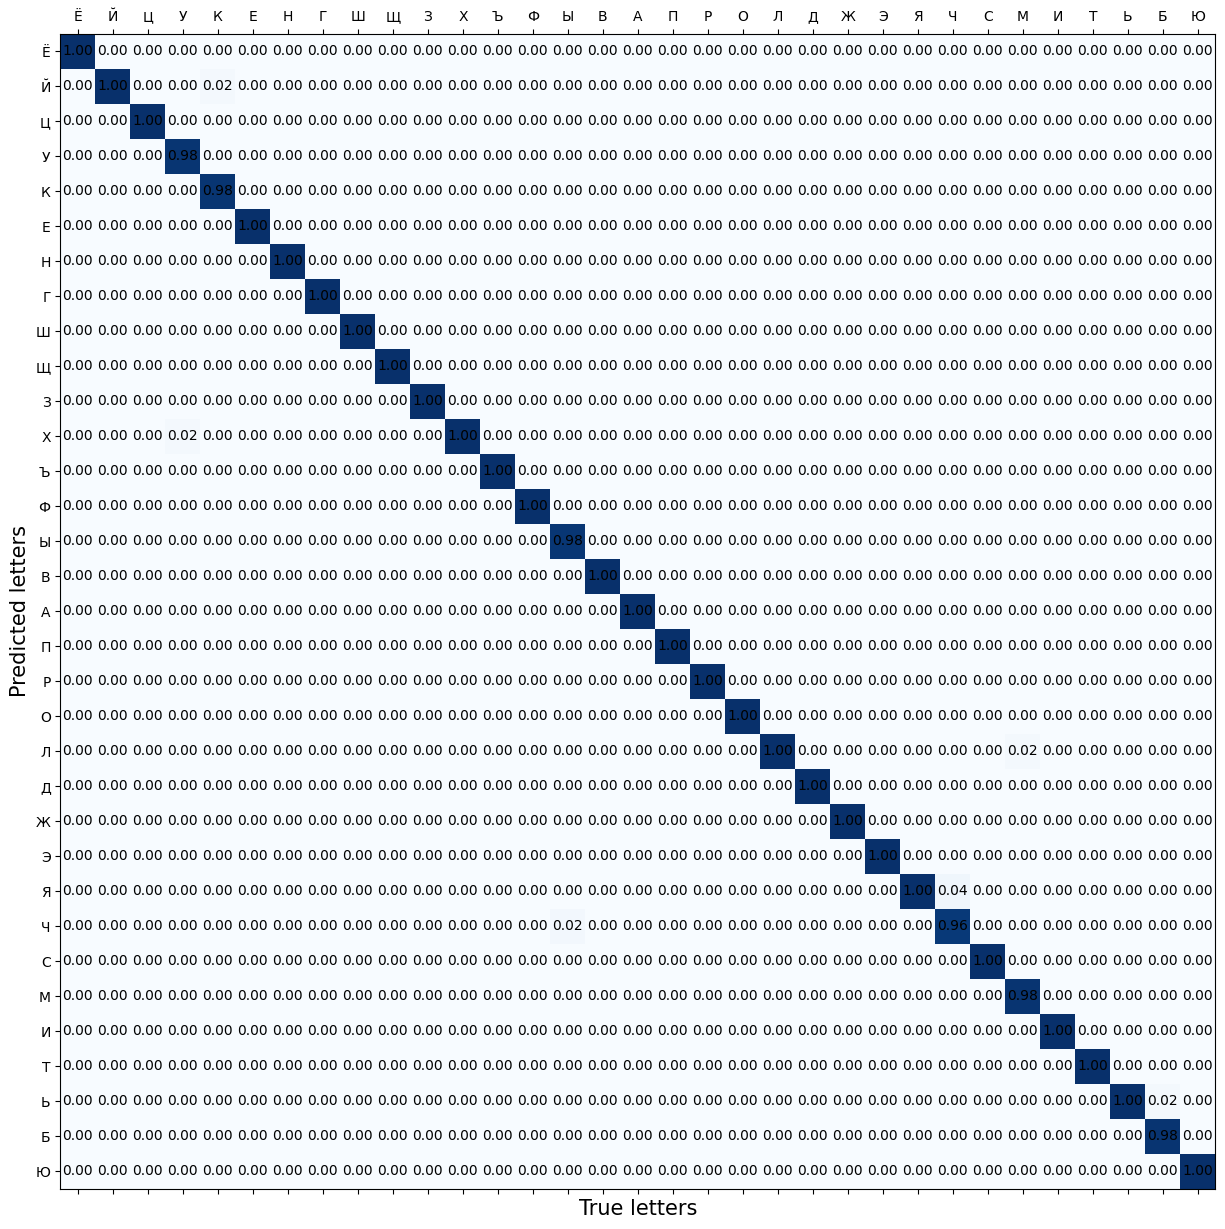

In [67]:
fig, ax = plt.subplots(figsize=(15,15))
ax.matshow(mat, cmap='Blues')
ax.set_xticks(range(len(captions_base)), captions_base)
ax.set_yticks(range(len(captions_base)), captions_base)
for i in range(len(captions_base)):
    for j in range(len(captions_base)):
        c = mat[j,i]
        ax.text(i, j, f'{c:.2f}', va='center', ha='center')
ax.set_xlabel('True letters', fontsize=15)
ax.set_ylabel('Predicted letters', fontsize=15)

In [32]:
n = 946
img = test_aug.images[n]
print(test_aug.captions[n],captions_base[model.predict(img.reshape((1,*img.shape,1))).argmax()])
plt.imshow(img, cmap='gray')

IndexError: list index out of range

In [68]:
model.save('models/conv_letter_recognizer.keras')

# Transformer

In [33]:
import keras_nlp

In [34]:
inputs = keras.Input(shape=(*np.array(aug.images).shape[1:],1) )
reshaped = keras.layers.Reshape(np.array(aug.images).shape[1:])(inputs)
encoded = keras_nlp.layers.TransformerEncoder(intermediate_dim=1024, num_heads=24)(reshaped)
encoded = keras_nlp.layers.TransformerEncoder(intermediate_dim=1024, num_heads=24)(encoded)
encoded = keras_nlp.layers.TransformerEncoder(intermediate_dim=1024, num_heads=24)(encoded)
encoded = keras_nlp.layers.TransformerEncoder(intermediate_dim=1024, num_heads=24)(encoded)
dense = keras.layers.Flatten()(encoded)
dense = keras.layers.Dense(1024, activation='relu')(dense)
dense = keras.layers.Dense(512, activation='relu')(dense)
dense = keras.layers.Dense(256, activation='relu')(dense)
outputs = keras.layers.Dense(num_letters, activation='softmax')(dense)


vit_model = keras.Model(inputs=inputs, outputs=outputs)
vit_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 1)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ reshape (Reshape)               │ (None, 32, 32)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ transformer_encoder             │ (None, 32, 32)            │     69,896 │
│ (TransformerEncoder)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ transformer_encoder_1           │ (None, 32, 32)            │     69,896 │
│ (TransformerEncoder)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ transformer_encoder_2           │ (None, 32, 32)            │     69,896 │
│ (TransformerEncoder)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ transformer_encoder_3           │ (None, 32, 32)            │     69,896 │
│ (TransformerEncoder)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_2 (Flatten)             │ (None, 1024)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_8 (Dense)                 │ (None, 1024)              │  1,049,600 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_9 (Dense)                 │ (None, 512)               │    524,800 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_10 (Dense)                │ (None, 256)               │    131,328 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_11 (Dense)                │ (None, 33)                │      8,481 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 1,993,793 (7.61 MB)

 Trainable params: 1,993,793 (7.61 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
vit_model.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'], optimizer='adam')

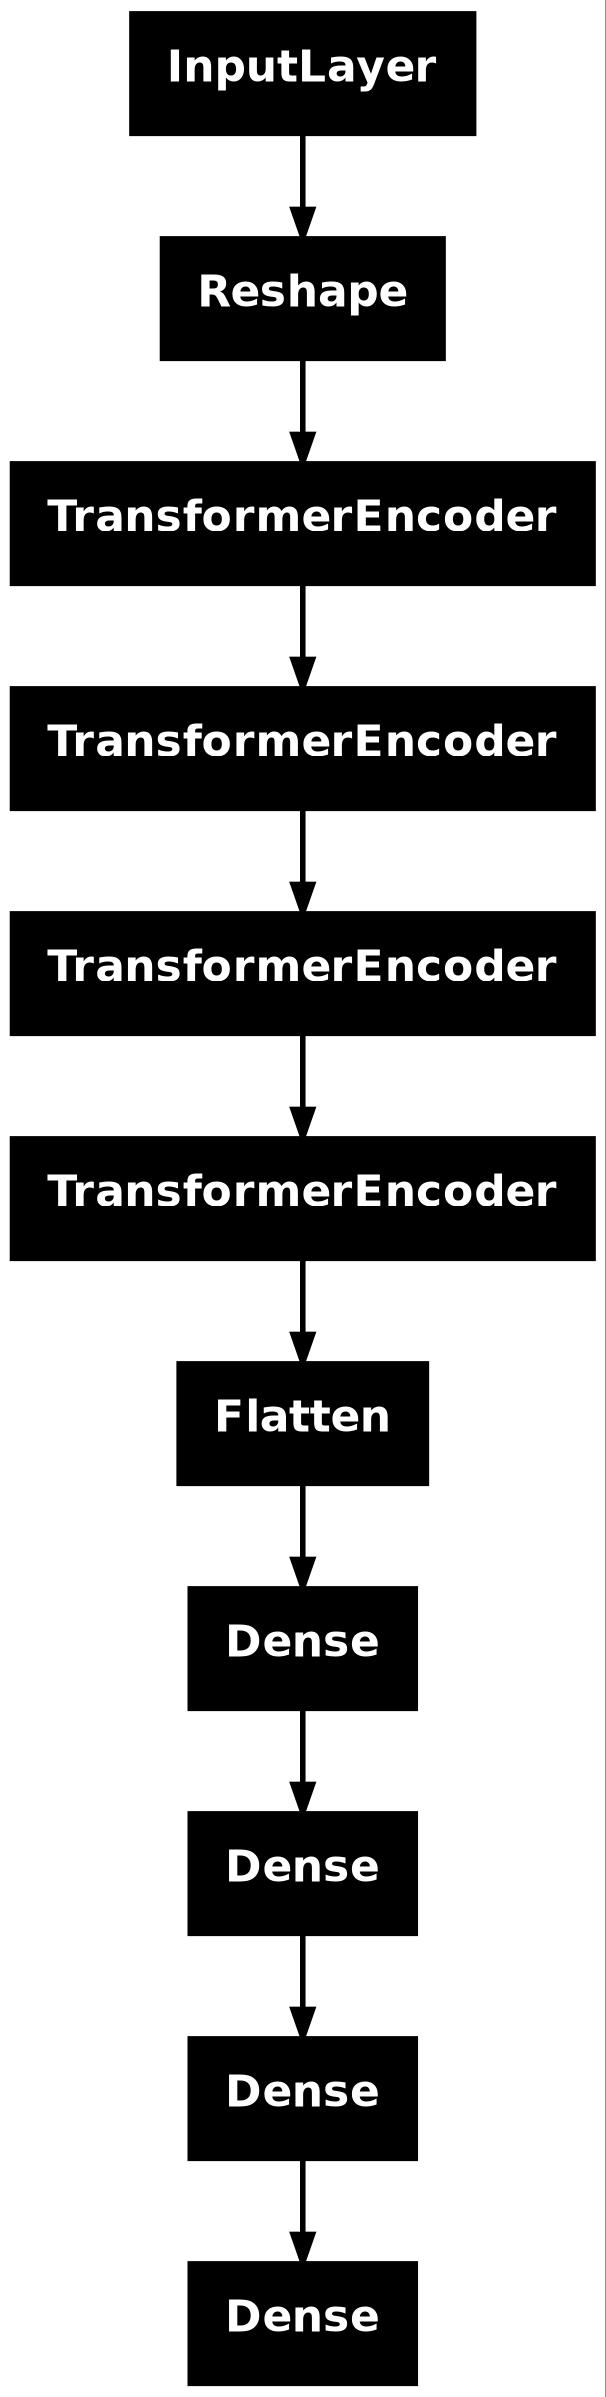

In [36]:
keras.utils.plot_model(vit_model,'models/ViT.jpg')

In [37]:
his = vit_model.fit(x_data, y_data,
          epochs=50,
          batch_size=128,
          shuffle=True,
          validation_split=0.2,
          callbacks=[reduce_lr, early_stop, tensorboard],
                )

Epoch 1/50
13/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - categorical_accuracy: 0.0636 - loss: 3.5235

W0000 00:00:1706883372.806473    3133 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - categorical_accuracy: 0.1308 - loss: 3.1831

W0000 00:00:1706883376.345948    3131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1706883377.253234    3132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - categorical_accuracy: 0.1337 - loss: 3.1697 - val_categorical_accuracy: 0.4744 - val_loss: 1.7142 - learning_rate: 0.0010
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.5613 - loss: 1.4053 - val_categorical_accuracy: 0.7188 - val_loss: 0.8219 - learning_rate: 0.0010
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.7808 - loss: 0.6767 - val_categorical_accuracy: 0.8571 - val_loss: 0.4802 - learning_rate: 0.0010
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.8957 - loss: 0.3585 - val_categorical_accuracy: 0.8679 - val_loss: 0.4265 - learning_rate: 0.0010
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.9280 - loss: 0.2351 - val_categorical_accuracy: 0.9479 - val_loss: 0.1872 - learning_rate: 0.0010
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.9735 - loss: 0.1102 - val_categorical_accuracy: 0.9515 - 

<Axes: >

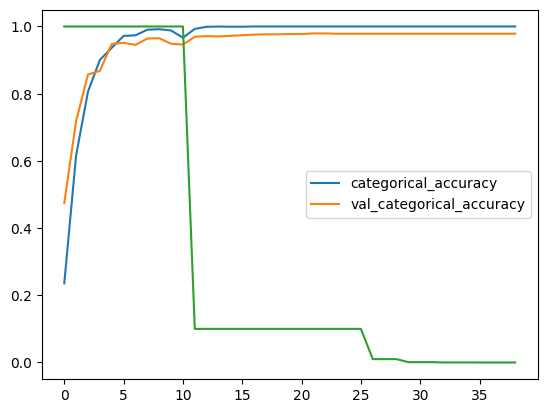

In [38]:
his_df = pd.DataFrame(his.history)
his_df[['categorical_accuracy', 'val_categorical_accuracy']].plot()
(his_df['learning_rate'] * 1000).plot()

In [39]:
vit_model.evaluate(test_x_data, test_y_data), model.evaluate(test_x_data, test_y_data), test_x_data.shape

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - categorical_accuracy: 0.9917 - loss: 0.0386
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9864 - loss: 0.0504


([0.114391028881073, 0.9742404222488403],
 [0.16044366359710693, 0.95772784948349],
 (1514, 32, 32, 1))

In [75]:
y_pred = vit_model.predict(test_x_data).argmax(axis=1)

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


Text(0, 0.5, 'Predicted letters')

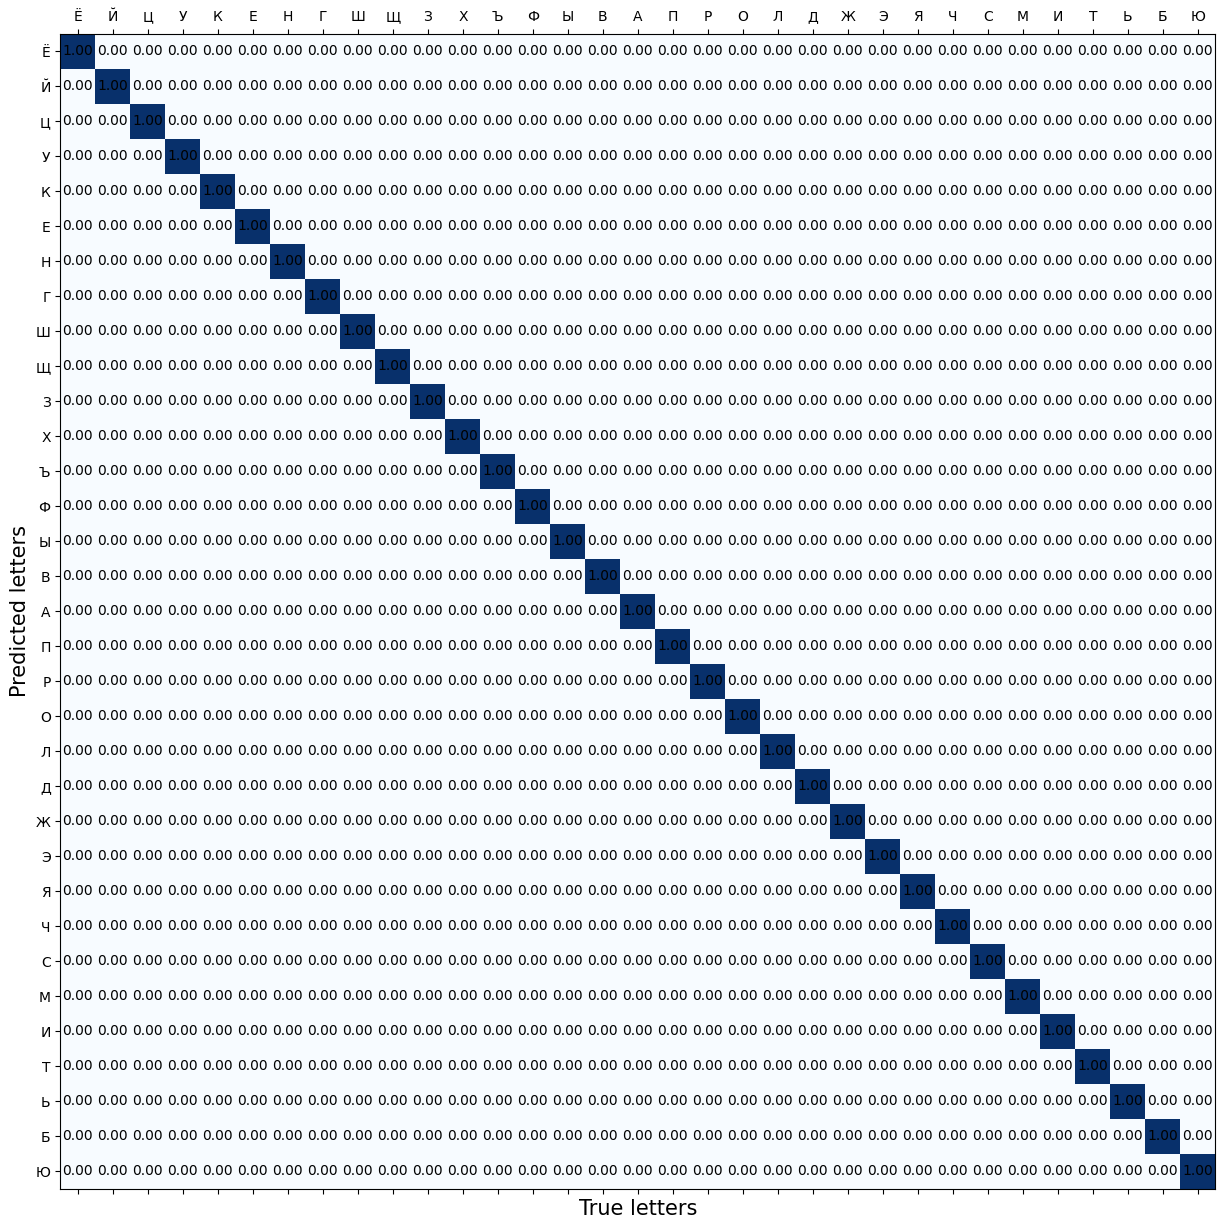

In [76]:

mat = np.zeros(shape=(num_letters,num_letters))
for i in range(len(y_pred)):
    true_ind = test_classes[i]
    pred_ind = y_pred[i]    
    mat[true_ind, pred_ind]+=1

mat=mat/mat.sum(axis=0)

fig, ax = plt.subplots(figsize=(15,15))
ax.matshow(mat, cmap='Blues')
ax.set_xticks(range(len(captions_base)), captions_base)
ax.set_yticks(range(len(captions_base)), captions_base)
for i in range(len(captions_base)):
    for j in range(len(captions_base)):
        c = mat[j,i]
        ax.text(i, j, f'{c:.2f}', va='center', ha='center')
ax.set_xlabel('True letters', fontsize=15)
ax.set_ylabel('Predicted letters', fontsize=15)

In [77]:
vit_model.save('models/vit_letter_recognizer.keras')

# LeViT-like

In [ ]:
filters = 128

def applyMHA(layer, shrink=False, num_heads=4, key_dim=33):    
    
    if shrink:
        layer_shrinked = keras.layers.MaxPool2D()(layer)
        return keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(layer_shrinked,layer,layer)
    else:
        MHA = keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(layer,layer,layer)
        return keras.layers.Add()([layer,MHA])

def addMLP(layer, factor = 2, activation='tanh'):
    MLP = keras.layers.Dense(filters*factor, activation=activation)(layer)
    MLP = keras.layers.Dense(filters, activation=activation)(MLP)    
    return keras.layers.Add()([layer,MLP])
    

In [ ]:
inputs = keras.Input(shape=(*np.array(aug.images).shape[1:],1) )
conv = keras.layers.Conv2D(filters=filters, kernel_size=(3,3),strides=2, activation='relu', padding='same')(inputs)
# conv = keras.layers.Conv2D(filters=128, kernel_size=(3,3),strides=3, activation='relu', padding='same')(conv)
block1 = applyMHA(conv)
block1 = addMLP(block1)
block1 = applyMHA(block1)
block1 = addMLP(block1)

block1 = applyMHA(block1, shrink=True, num_heads=16, key_dim=16)

block2 = addMLP(block1)
block2 = applyMHA(block2)
block2 = addMLP(block2)

dense = keras.layers.Flatten()(block2)
dense = keras.layers.Dense(1024, activation='relu')(dense)
dense = keras.layers.Dense(512, activation='relu')(dense)
dense = keras.layers.Dense(256, activation='relu')(dense)
outputs = keras.layers.Dense(num_letters, activation='softmax')(dense)

levit = keras.models.Model(inputs=inputs, outputs=outputs)
levit.summary()

In [ ]:
levit.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'], optimizer='adam')

In [ ]:
his = levit.fit(x_data, y_data,
          epochs=50,
          batch_size=128,
          shuffle=True,
          validation_split=0.2,
          callbacks=[reduce_lr, early_stop, tensorboard],
                )

# ViT (with patches)

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import keras
from keras import layers
from keras import ops

import numpy as np
import matplotlib.pyplot as plt

tf.__version__, keras.__version__

In [ ]:
class ViT_Config():
    
    learning_rate = 0.001
    weight_decay = 0.0001
    batch_size = 256
    
    image_size = 32  # We'll resize input images to this size
    patch_size = 6  # Size of the patches to be extract from the input images
    projection_dim = 128
    transformer_layers = 16
    
    num_heads = 8

    mlp_head_units = [
        2048,
        1024,
        512
    ] 
    
    def __init__(self, image_size, patch_size, projection_dim, transformer_layers):
        self.image_size =image_size
        self.patch_size = patch_size
        self.projection_dim = projection_dim 
        self.transformer_layers = transformer_layers
        self.num_patches = (self.image_size // patch_size) ** 2
        self.transformer_units = [
        projection_dim * 4,
        projection_dim,
    ]

        
config = ViT_Config(20, 6, 128, 7)

In [ ]:
def data_augmentation(conf):
    data_augmentation = keras.Sequential(
        [
            layers.Normalization(),
            layers.Resizing(conf.image_size, conf.image_size),
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(factor=0.02),
            layers.RandomZoom(height_factor=0.2, width_factor=0.2),
        ],
        name="data_augmentation",
    )
    # Compute the mean and the variance of the training data for normalization.
    data_augmentation.layers[0].adapt(x_data)
    return data_augmentation

In [ ]:
def vit_mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images_list):
        input_shape = ops.shape(images_list)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images_list, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

In [ ]:
def create_vit_classifier(vit_config):
    inputs = keras.Input(shape=(*np.array(aug.images).shape[1:],1), name='inputs')
    # Augment data.
    augmented = data_augmentation(vit_config)(inputs)
    # Create patches.
    patches = Patches(vit_config.patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(vit_config.num_patches, vit_config.projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(vit_config.transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=vit_config.num_heads, key_dim=vit_config.projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = vit_mlp(x3, hidden_units=vit_config.transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = vit_mlp(representation, hidden_units=vit_config.mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_letters)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

vit_classifier = create_vit_classifier(config)
vit_classifier.summary()

In [ ]:
image_sizes = [32, 48, 64, 80]
patch_sizes = range(4,10,2)
hidden_dims = range(16,512,64)
transformer_layers = range(1,25,2)


param_grid = []

for im in image_sizes:
    for ps in patch_sizes:
        for hd in hidden_dims:
            for trl in transformer_layers:
                param_grid.append([im, ps, hd, trl])
                
len(param_grid)

In [ ]:
def run(vit_config, n):
    vit_classifier = create_vit_classifier(config)
    optimizer = keras.optimizers.AdamW(
            learning_rate=vit_config.learning_rate, weight_decay=vit_config.weight_decay
        )
    vit_classifier.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'], optimizer='adam')
    checkpoint_filepath = f"tmp/checkpoint{n}.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
            checkpoint_filepath,
            monitor="val_categorical_accuracy",
            save_best_only=True,
            save_weights_only=True,
        )
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_delta = 1e-5,
                                  patience=9, min_lr=1e-20)
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=7)
    tensorboard = keras.callbacks.TensorBoard(log_dir="./logs")
    history = vit_classifier.fit(
        x_data, y_data,
              epochs=50,
              batch_size=16,
              shuffle=True,
              validation_split=0.2,
              callbacks=[tensorboard, checkpoint_callback, early_stop],
                    )
    eval = vit_classifier.evaluate(test_x_data, test_y_data)
    return history.history, eval

In [ ]:
his = []
res = []

for n, param in enumerate(param_grid):
    config = ViT_Config(*param)
    print(f"\n Step {n}.\n Config:{param}\n\n")
    train_step, eval_step = run(config, n)
    his.append(train_step)
    res.append(eval_step)

In [ ]:
vit_classifier.evaluate(x_data, y_data)